In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.cm
from matplotlib import colors
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import sklearn.cluster as sklc  # For clustering
import sklearn.metrics as sklm  # For the silhouette score
from sklearn.preprocessing import RobustScaler

import statsmodels
import statsmodels.api as sm

# Read data

In [2]:
# read data into a DataFrame
df = pd.read_csv("data/need_2021_anon_dataset_50k.csv")

print(df.shape)

(50000, 75)


In [3]:
df.head()

,PROP_TYPE,PROP_AGE_BAND,FLOOR_AREA_BAND,CONSERVATORY_FLAG,COUNCIL_TAX_BAND,IMD_BAND_ENG,IMD_BAND_WALES,REGION,LI_FLAG,LI_DATE,...,ElecValFlag2014,ElecValFlag2013,ElecValFlag2012,ElecValFlag2011,ElecValFlag2010,ElecValFlag2009,ElecValFlag2008,ElecValFlag2007,ElecValFlag2006,ElecValFlag2005
0,Mid terrace,2,3,NaN,B,2.0,NaN,E12000005,0,NaN,...,V,E,E,V,E,V,V,V,V,V
1,Flat,3,2,NaN,A,1.0,NaN,E12000008,0,NaN,...,V,V,V,V,V,V,V,V,V,V
2,Mid terrace,1,3,NaN,A,2.0,NaN,E12000001,0,NaN,...,V,V,V,V,V,V,V,V,V,V
3,Flat,4,1,0.0,A,3.0,NaN,E12000004,0,NaN,...,O,O,O,O,O,O,O,O,O,O
4,Semi detached,2,2,NaN,D,5.0,NaN,E12000008,0,NaN,...,V,V,V,V,V,V,V,V,V,V


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 75 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PROP_TYPE          50000 non-null  object 
 1   PROP_AGE_BAND      50000 non-null  int64  
 2   FLOOR_AREA_BAND    50000 non-null  int64  
 3   CONSERVATORY_FLAG  7418 non-null   float64
 4   COUNCIL_TAX_BAND   50000 non-null  object 
 5   IMD_BAND_ENG       47410 non-null  float64
 6   IMD_BAND_WALES     2590 non-null   float64
 7   REGION             50000 non-null  object 
 8   LI_FLAG            50000 non-null  int64  
 9   LI_DATE            8568 non-null   float64
 10  CWI_FLAG           50000 non-null  int64  
 11  CWI_DATE           8412 non-null   float64
 12  PV_FLAG            50000 non-null  int64  
 13  PV_DATE            561 non-null    float64
 14  MAIN_HEAT_FUEL     50000 non-null  int64  
 15  Gcons2019          40329 non-null  float64
 16  Gcons2018          403

# Wrangle data
## Select rows

In [5]:
# Select rows where the 'IMD_BAND_ENG' column is not NaN
df = df[df['IMD_BAND_ENG'].notna()]

print(df.shape)

(47410, 75)


## Select columns

In [6]:
columns_of_interest = [
    'PROP_TYPE', 'PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND',
    'IMD_BAND_ENG', 'REGION', 'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL',
    'Gcons2019', 'Gcons2018', 'Gcons2017', 'Gcons2016', 'Gcons2015', 'Gcons2014', 'Gcons2013', 'Gcons2012', 'Gcons2011', 'Gcons2010', 'Gcons2009', 'Gcons2008', 'Gcons2007', 'Gcons2006', 'Gcons2005',
    'Econs2019', 'Econs2018', 'Econs2017', 'Econs2016', 'Econs2015', 'Econs2014', 'Econs2013', 'Econs2012', 'Econs2011', 'Econs2010', 'Econs2009', 'Econs2008', 'Econs2007', 'Econs2006', 'Econs2005'
]

df_filtered = df[columns_of_interest].copy()
print(df_filtered.shape)

(47410, 40)


## Change datatype

In [7]:
tax_band_mapping = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7}
df_filtered['COUNCIL_TAX_BAND'] = df_filtered['COUNCIL_TAX_BAND'].map(tax_band_mapping)

df_filtered.head()

,PROP_TYPE,PROP_AGE_BAND,FLOOR_AREA_BAND,COUNCIL_TAX_BAND,IMD_BAND_ENG,REGION,LI_FLAG,CWI_FLAG,PV_FLAG,MAIN_HEAT_FUEL,...,Econs2014,Econs2013,Econs2012,Econs2011,Econs2010,Econs2009,Econs2008,Econs2007,Econs2006,Econs2005
0,Mid terrace,2,3,1,2.0,E12000005,0,0,0,1,...,2200.0,4200.0,4200.0,4200.0,3800.0,3800.0,3600.0,3400.0,3100.0,20400.0
1,Flat,3,2,0,1.0,E12000008,0,0,0,1,...,2100.0,2400.0,2200.0,2600.0,2000.0,2200.0,4300.0,2300.0,1800.0,2900.0
2,Mid terrace,1,3,0,2.0,E12000001,0,0,0,1,...,3100.0,2900.0,2600.0,2700.0,2500.0,3200.0,3100.0,2200.0,2000.0,2000.0
3,Flat,4,1,0,3.0,E12000004,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Semi detached,2,2,3,5.0,E12000008,0,0,0,2,...,10900.0,9300.0,11500.0,9700.0,12300.0,12700.0,12900.0,13000.0,11900.0,13500.0


## Dealing with NaN

In [8]:
# Define the columns of interest
g_columns = [f'Gcons{i}' for i in range(2019, 2004, -1)]
e_columns = [f'Econs{i}' for i in range(2019, 2004, -1)]

# Drop rows where both Gcons and Econs columns are NaN
df_filtered = df_filtered.dropna(subset=g_columns + e_columns, how='all')

print(df_filtered.shape)
df_filtered.info()

(47335, 40)
<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  int64  
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         38309 non-null  float64
 11  Gcons2018         38318 non-null  float64
 12  Gcons2017         38206 non-null  float64
 13  Gcons2016         37731 non-null  float64
 14  Gcons2015         37236 non-null  float64
 15  Gcons2014         36954 non-null  float64
 16  Gcons2013         36639 non-null 

In [9]:
# fill NaN with 0 if both Gcons or Econs columns are NaN
condition1 = df_filtered.iloc[:, 10:25].isna().all(axis=1)
df_filtered.loc[condition1, df_filtered.columns[10:25]] = 0

condition2 = df_filtered.iloc[:, 25:].isna().all(axis=1)
df_filtered.loc[condition2, df_filtered.columns[25:]] = 0

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  int64  
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         46100 non-null  float64
 11  Gcons2018         46109 non-null  float64
 12  Gcons2017         45997 non-null  float64
 13  Gcons2016         45522 non-null  float64
 14  Gcons2015         45027 non-null  float64
 15  Gcons2014         44745 non-null  float64
 16  Gcons2013         44430 non-null  float64
 17

In [10]:
# fill other NaN with the median of the column
df_filtered.iloc[:, 10:] = df_filtered.iloc[:, 10:].apply(lambda col: col.fillna(col.median()), axis=0)

# 循环遍历2005年到2019年
for year in range(2005, 2020):
    # 构造列名
    gcons_col = 'Gcons' + str(year)
    econs_col = 'Econs' + str(year)
    sum_col = 'Sum' + str(year)
    
    # 将相应年份的 'Gcons' 和 'Econs' 相加，存储到新列
    df_filtered[sum_col] = df_filtered[gcons_col] + df_filtered[econs_col]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  int64  
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         47335 non-null  float64
 11  Gcons2018         47335 non-null  float64
 12  Gcons2017         47335 non-null  float64
 13  Gcons2016         47335 non-null  float64
 14  Gcons2015         47335 non-null  float64
 15  Gcons2014         47335 non-null  float64
 16  Gcons2013         47335 non-null  float64
 17

# Regression analysis

## One-hot encoding

In [11]:
df_filtered_numeric = pd.get_dummies(df_filtered, dtype=int)

df_filtered_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 68 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PROP_AGE_BAND            47335 non-null  int64  
 1   FLOOR_AREA_BAND          47335 non-null  int64  
 2   COUNCIL_TAX_BAND         47335 non-null  int64  
 3   IMD_BAND_ENG             47335 non-null  float64
 4   LI_FLAG                  47335 non-null  int64  
 5   CWI_FLAG                 47335 non-null  int64  
 6   PV_FLAG                  47335 non-null  int64  
 7   MAIN_HEAT_FUEL           47335 non-null  int64  
 8   Gcons2019                47335 non-null  float64
 9   Gcons2018                47335 non-null  float64
 10  Gcons2017                47335 non-null  float64
 11  Gcons2016                47335 non-null  float64
 12  Gcons2015                47335 non-null  float64
 13  Gcons2014                47335 non-null  float64
 14  Gcons2013                47

## Checking the correlation between variables

Text(0.5, 1.0, 'Correlation Matrix')

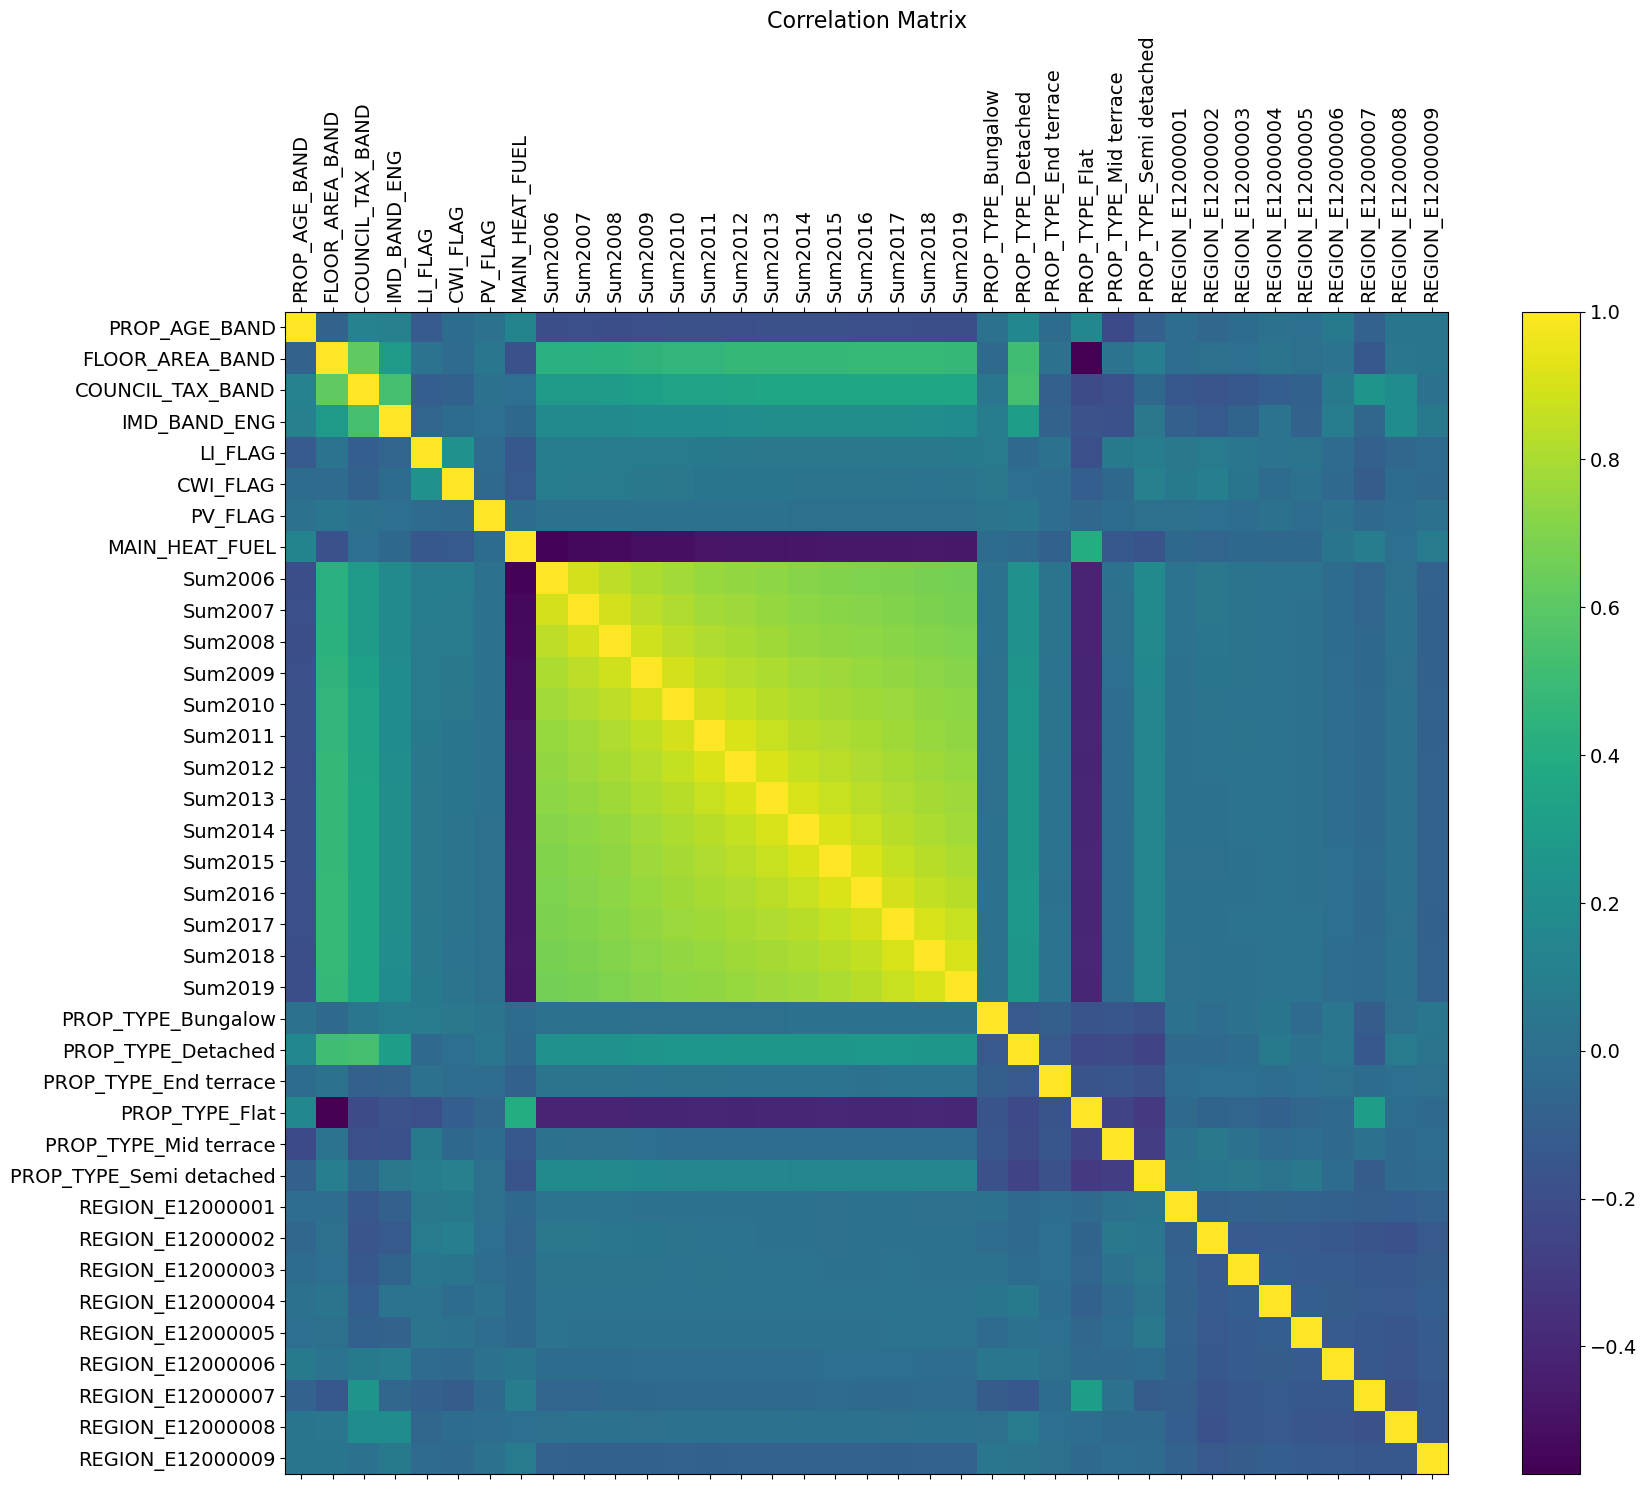

In [12]:
df_filtered_independent = df_filtered_numeric.drop(df_filtered_numeric.columns[8:39], axis=1)

plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df_filtered_independent.corr(), fignum=f.number)
plt.xticks(range(df_filtered_independent.shape[1]), df_filtered_independent.columns, fontsize=14, rotation=90)
plt.yticks(range(df_filtered_independent.shape[1]), df_filtered_independent.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

## Using VIF to deal with multicollinearity

In [13]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [14]:
# using VIF on the df
df_filtered_VIF = drop_column_using_vif_(df_filtered_numeric.drop(df_filtered_numeric.columns[8:39], axis=1))

# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_filtered_VIF.columns)

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping: PROP_TYPE_Bungalow


/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping: REGION_E12000001
Dropping: Sum2015
Dropping: Sum2012
Dropping: Sum2018
Dropping: Sum2010
Dropping: Sum2013
Dropping: Sum2007
Dropping: Sum2016
Dropping: Sum2009
Dropping: Sum2017
The columns remaining after VIF selection are:
Index(['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND', 'IMD_BAND_ENG',
       'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL', 'Sum2006',
       'Sum2008', 'Sum2011', 'Sum2014', 'Sum2019', 'PROP_TYPE_Detached',
       'PROP_TYPE_End terrace', 'PROP_TYPE_Flat', 'PROP_TYPE_Mid terrace',
       'PROP_TYPE_Semi detached', 'REGION_E12000002', 'REGION_E12000003',
       'REGION_E12000004', 'REGION_E12000005', 'REGION_E12000006',
       'REGION_E12000007', 'REGION_E12000008', 'REGION_E12000009'],
      dtype='object')


In [15]:
import os
# 创建 Data_clean文件夹
data_folder = "Data_clean"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# 导出 DataFrame 到 CSV 文件
output_file = os.path.join(data_folder, "sum.csv")
df_filtered_numeric.to_csv(output_file, index=False)

## Regression

### Gcons2019

In [16]:
Gcons2019_comsumption = sm.OLS(endog=np.log1p(df_filtered_numeric[['Gcons2019']]), exog=sm.add_constant(df_filtered_VIF)).fit()
Gcons2019_comsumption.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gcons2019   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                 2.190e+04
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:57:57   Log-Likelihood:                -65779.
No. Observations:               47335   AIC:                         1.316e+05
Df Residuals:                   47308   BIC:                         1.318e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      15.6422      0.043    364.766      0.000      15.558      15.726
PROP_AGE_BAND               0.0151      0.005      2.985      0.003       0.005       0.025
FLOOR_AREA_BAND            -0.1110      0.009    -12.551      0.000      -0.128      -0.094
COUNCIL_TAX_BAND           -0.0825      0.006    -14.998      0.000      -0.093      -0.072
IMD_BAND_ENG                0.0076      0.004      1.913      0.056      -0.000       0.015
LI_FLAG                     0.0121      0.013      0.959      0.337      -0.013       0.037
CWI_FLAG                    0.0386      0.013      3.082      0.002       0.014       0.063
PV_FLAG                     0.0128      0.042      0.302      0.763      -0.070       0.096
MAIN_HEAT_FUEL             -7.5839      0.016   -487.414      0.000      -7.614      -7.553
Sum2006                  1.108e-05   8.42e-07     13.159      0.000    9.43e-06    1.27e-05
Sum2008                  4.978e-06   9.53e-07      5.221      0.000    3.11e-06    6.85e-06
Sum2011                 -2.544e-07   1.04e-06     -0.245      0.806   -2.29e-06    1.78e-06
Sum2014                  1.591e-06   1.04e-06      1.532      0.125   -4.44e-07    3.63e-06
Sum2019                  7.562e-05   8.67e-07     87.198      0.000    7.39e-05    7.73e-05
PROP_TYPE_Detached          0.0100      0.021      0.479      0.632      -0.031       0.051
PROP_TYPE_End terrace       0.0487      0.022      2.232      0.026       0.006       0.091
PROP_TYPE_Flat             -0.1810      0.021     -8.778      0.000      -0.221      -0.141
PROP_TYPE_Mid terrace       0.0765      0.019      3.971      0.000       0.039       0.114
PROP_TYPE_Semi detached     0.0068      0.018      0.382      0.702      -0.028       0.042
REGION_E12000002           -0.0084      0.023     -0.359      0.720      -0.054       0.037
REGION_E12000003           -0.0142      0.024     -0.582      0.561      -0.062       0.034
REGION_E12000004           -0.0178      0.025     -0.705      0.481      -0.067       0.032
REGION_E12000005           -0.0130      0.024     -0.531      0.595      -0.061       0.035
REGION_E12000006           -0.0308      0.025     -1.252      0.210      -0.079       0.017
REGION_E12000007            0.1159      0.027      4.349      0.000       0.064       0.168
REGION_E12000008            0.0137      0.024      0.568      0.570      -0.033       0.061
REGION_E12000009           -0.0384      0.025     -1.539      0.124      -0.087       0.011
==============================================================================
Omnibus:                    48023.192   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5222463.531
Skew:                           4.832   Prob(JB):                         0.00
Kurtosi

## Drop columns that are not significant

In [17]:
def looper(limit):
    cols = ['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND', 'IMD_BAND_ENG',
       'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL',
       'PROP_TYPE_Bungalow', 'PROP_TYPE_End terrace', 'PROP_TYPE_Flat',
       'PROP_TYPE_Mid terrace', 'PROP_TYPE_Semi detached', 'REGION_E12000002',
       'REGION_E12000003', 'REGION_E12000004', 'REGION_E12000005',
       'REGION_E12000006', 'REGION_E12000007', 'REGION_E12000008',
       'REGION_E12000009']
    for i in range(len(cols)):
        data1 = df_filtered_numeric[cols]
        x = sm.add_constant(data1) #生成自变量
        y = np.log1p(df_filtered_numeric['Gcons2019']) #生成因变量
        model = sm.OLS(y, x) #生成模型
        result = model.fit() #模型拟合
        pvalues = result.pvalues #得到结果中所有P值
        pvalues.drop('const',inplace=True) #把const取得
        pmax = max(pvalues) #选出最大的P值
        if pmax>limit:
            ind = pvalues.idxmax() #找出最大P值的index
            cols.remove(ind) #把这个index从cols中删除
        else:
            return result
 
Gcons2019_comsumption_result = looper(0.05)
Gcons2019_comsumption_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gcons2019   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                 4.075e+04
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:57:57   Log-Likelihood:                -72987.
No. Observations:               47335   AIC:                         1.460e+05
Df Residuals:                   47324   BIC:                         1.461e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    17.9423      0.029    609.194      0.000      17.885      18.000
PROP_AGE_BAND            -0.1213      0.006    -21.787      0.000      -0.132      -0.110
FLOOR_AREA_BAND           0.0833      0.009      8.971      0.000       0.065       0.101
COUNCIL_TAX_BAND          0.0365      0.004      8.332      0.000       0.028       0.045
MAIN_HEAT_FUEL           -8.4926      0.015   -559.605      0.000      -8.522      -8.463
PROP_TYPE_Bungalow       -0.0656      0.019     -3.390      0.001      -0.104      -0.028
PROP_TYPE_Flat           -0.3333      0.018    -18.387      0.000      -0.369      -0.298
PROP_TYPE_Mid terrace    -0.1092      0.015     -7.442      0.000      -0.138      -0.080
REGION_E12000006         -0.1203      0.017     -7.063      0.000      -0.154      -0.087
REGION_E12000008         -0.1163      0.015     -7.806      0.000      -0.145      -0.087
REGION_E12000009         -0.2456      0.018    -13.777      0.000      -0.281      -0.211
==============================================================================
Omnibus:                    42279.045   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3764189.408
Skew:                           3.936   Prob(JB):                         0.00
Kurtosis:                      45.972   Cond. No.                         27.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Econs2019

In [18]:
Econs2019_comsumption = sm.OLS(endog=np.log1p(df_filtered_numeric[['Econs2019']]), exog=sm.add_constant(df_filtered_VIF)).fit()
Econs2019_comsumption.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Econs2019   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     339.6
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:57:58   Log-Likelihood:                -73566.
No. Observations:               47335   AIC:                         1.472e+05
Df Residuals:                   47308   BIC:                         1.474e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       5.4348      0.051    107.511      0.000       5.336       5.534
PROP_AGE_BAND               0.0864      0.006     14.492      0.000       0.075       0.098
FLOOR_AREA_BAND            -0.0419      0.010     -4.018      0.000      -0.062      -0.021
COUNCIL_TAX_BAND           -0.0309      0.006     -4.764      0.000      -0.044      -0.018
IMD_BAND_ENG               -0.0162      0.005     -3.454      0.001      -0.025      -0.007
LI_FLAG                     0.0212      0.015      1.429      0.153      -0.008       0.050
CWI_FLAG                    0.0935      0.015      6.337      0.000       0.065       0.122
PV_FLAG                    -0.0049      0.050     -0.098      0.922      -0.103       0.093
MAIN_HEAT_FUEL              1.2612      0.018     68.762      0.000       1.225       1.297
Sum2006                  4.676e-06   9.92e-07      4.712      0.000    2.73e-06    6.62e-06
Sum2008                  3.109e-06   1.12e-06      2.766      0.006    9.06e-07    5.31e-06
Sum2011                  1.085e-06   1.22e-06      0.887      0.375   -1.31e-06    3.48e-06
Sum2014                  2.021e-06   1.22e-06      1.652      0.099   -3.77e-07    4.42e-06
Sum2019                  4.682e-05   1.02e-06     45.793      0.000    4.48e-05    4.88e-05
PROP_TYPE_Detached          0.0695      0.025      2.827      0.005       0.021       0.118
PROP_TYPE_End terrace       0.1047      0.026      4.074      0.000       0.054       0.155
PROP_TYPE_Flat             -0.4279      0.024    -17.602      0.000      -0.476      -0.380
PROP_TYPE_Mid terrace       0.1653      0.023      7.286      0.000       0.121       0.210
PROP_TYPE_Semi detached     0.1480      0.021      7.064      0.000       0.107       0.189
REGION_E12000002           -0.0287      0.027     -1.046      0.295      -0.083       0.025
REGION_E12000003           -0.0075      0.029     -0.260      0.795      -0.064       0.049
REGION_E12000004           -0.0157      0.030     -0.529      0.597      -0.074       0.043
REGION_E12000005           -0.0035      0.029     -0.123      0.902      -0.060       0.053
REGION_E12000006            0.1403      0.029      4.831      0.000       0.083       0.197
REGION_E12000007            0.0683      0.031      2.175      0.030       0.007       0.130
REGION_E12000008            0.1128      0.028      3.983      0.000       0.057       0.168
REGION_E12000009            0.1105      0.029      3.758      0.000       0.053       0.168
==============================================================================
Omnibus:                    46402.917   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1980872.165
Skew:                          -4.960   Prob(JB):                         0.00
Kurtosi

## Drop columns that are not significant

In [19]:
def looper(limit):
    cols = ['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND', 'IMD_BAND_ENG',
       'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL',
       'PROP_TYPE_Bungalow', 'PROP_TYPE_End terrace', 'PROP_TYPE_Flat',
       'PROP_TYPE_Mid terrace', 'PROP_TYPE_Semi detached', 'REGION_E12000002',
       'REGION_E12000003', 'REGION_E12000004', 'REGION_E12000005',
       'REGION_E12000006', 'REGION_E12000007', 'REGION_E12000008',
       'REGION_E12000009']
    for i in range(len(cols)):
        data1 = df_filtered_numeric[cols]
        x = sm.add_constant(data1) #生成自变量
        y = np.log1p(df_filtered_numeric['Econs2019']) #生成因变量
        model = sm.OLS(y, x) #生成模型
        result = model.fit() #模型拟合
        pvalues = result.pvalues #得到结果中所有P值
        pvalues.drop('const',inplace=True) #把const取得
        pmax = max(pvalues) #选出最大的P值
        if pmax>limit:
            ind = pvalues.idxmax() #找出最大P值的index
            cols.remove(ind) #把这个index从cols中删除
        else:
            return result
 
Econs2019_comsumption_result = looper(0.05)
Econs2019_comsumption_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Econs2019   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     379.0
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:57:59   Log-Likelihood:                -75793.
No. Observations:               47335   AIC:                         1.516e+05
Df Residuals:                   47324   BIC:                         1.517e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       6.8994      0.031    219.089      0.000       6.838       6.961
FLOOR_AREA_BAND             0.0796      0.010      8.033      0.000       0.060       0.099
COUNCIL_TAX_BAND            0.0415      0.005      8.141      0.000       0.032       0.052
IMD_BAND_ENG               -0.0150      0.005     -3.176      0.001      -0.024      -0.006
CWI_FLAG                    0.0889      0.015      5.904      0.000       0.059       0.118
MAIN_HEAT_FUEL              0.7049      0.016     43.870      0.000       0.673       0.736
PROP_TYPE_Bungalow         -0.1048      0.021     -5.022      0.000      -0.146      -0.064
PROP_TYPE_Flat             -0.5814      0.020    -29.745      0.000      -0.620      -0.543
PROP_TYPE_Semi detached     0.0778      0.014      5.554      0.000       0.050       0.105
REGION_E12000002           -0.0432      0.017     -2.614      0.009      -0.076      -0.011
REGION_E12000006            0.0780      0.018      4.398      0.000       0.043       0.113
==============================================================================
Omnibus:                    43862.260   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1591852.367
Skew:                          -4.583   Prob(JB):                         0.00
Kurtosis:                      29.890   Cond. No.                         30.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Sum2019

In [20]:
Gcons2019_comsumption = sm.OLS(endog=np.log1p(df_filtered_numeric[['Sum2019']]), exog=sm.add_constant(df_filtered_VIF)).fit()
Gcons2019_comsumption.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Sum2019   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                 1.072e+04
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:57:59   Log-Likelihood:                -8945.9
No. Observations:               47335   AIC:                         1.795e+04
Df Residuals:                   47308   BIC:                         1.818e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       9.0620      0.013    702.067      0.000       9.037       9.087
PROP_AGE_BAND               0.0037      0.002      2.445      0.015       0.001       0.007
FLOOR_AREA_BAND            -0.0130      0.003     -4.867      0.000      -0.018      -0.008
COUNCIL_TAX_BAND           -0.0106      0.002     -6.431      0.000      -0.014      -0.007
IMD_BAND_ENG                0.0029      0.001      2.461      0.014       0.001       0.005
LI_FLAG                     0.0040      0.004      1.051      0.293      -0.003       0.011
CWI_FLAG                    0.0186      0.004      4.939      0.000       0.011       0.026
PV_FLAG                     0.0023      0.013      0.182      0.856      -0.023       0.027
MAIN_HEAT_FUEL             -0.5044      0.005   -107.696      0.000      -0.514      -0.495
Sum2006                  8.527e-07   2.53e-07      3.366      0.001    3.56e-07    1.35e-06
Sum2008                  3.039e-07   2.87e-07      1.059      0.290   -2.59e-07    8.66e-07
Sum2011                 -1.032e-06   3.12e-07     -3.302      0.001   -1.64e-06   -4.19e-07
Sum2014                 -1.231e-06   3.12e-07     -3.940      0.000   -1.84e-06   -6.19e-07
Sum2019                  6.508e-05   2.61e-07    249.308      0.000    6.46e-05    6.56e-05
PROP_TYPE_Detached         -0.0009      0.006     -0.137      0.891      -0.013       0.011
PROP_TYPE_End terrace       0.0096      0.007      1.465      0.143      -0.003       0.022
PROP_TYPE_Flat             -0.1648      0.006    -26.556      0.000      -0.177      -0.153
PROP_TYPE_Mid terrace       0.0099      0.006      1.706      0.088      -0.001       0.021
PROP_TYPE_Semi detached     0.0126      0.005      2.361      0.018       0.002       0.023
REGION_E12000002            0.0010      0.007      0.146      0.884      -0.013       0.015
REGION_E12000003            0.0080      0.007      1.091      0.275      -0.006       0.022
REGION_E12000004            0.0098      0.008      1.290      0.197      -0.005       0.025
REGION_E12000005            0.0182      0.007      2.475      0.013       0.004       0.033
REGION_E12000006            0.0233      0.007      3.150      0.002       0.009       0.038
REGION_E12000007            0.0007      0.008      0.092      0.927      -0.015       0.016
REGION_E12000008            0.0236      0.007      3.257      0.001       0.009       0.038
REGION_E12000009            0.0223      0.008      2.965      0.003       0.008       0.037
==============================================================================
Omnibus:                    15403.718   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83248.059
Skew:                          -1.472   Prob(JB):                         0.00
Kurtosi

## Drop columns that are not significant

In [21]:
def looper(limit):
    cols = ['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND', 'IMD_BAND_ENG',
       'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL',
       'PROP_TYPE_Bungalow', 'PROP_TYPE_End terrace', 'PROP_TYPE_Flat',
       'PROP_TYPE_Mid terrace', 'PROP_TYPE_Semi detached', 'REGION_E12000002',
       'REGION_E12000003', 'REGION_E12000004', 'REGION_E12000005',
       'REGION_E12000006', 'REGION_E12000007', 'REGION_E12000008',
       'REGION_E12000009']
    for i in range(len(cols)):
        data1 = df_filtered_numeric[cols]
        x = sm.add_constant(data1) #生成自变量
        y = np.log1p(df_filtered_numeric['Sum2019']) #生成因变量
        model = sm.OLS(y, x) #生成模型
        result = model.fit() #模型拟合
        pvalues = result.pvalues #得到结果中所有P值
        pvalues.drop('const',inplace=True) #把const取得
        pmax = max(pvalues) #选出最大的P值
        if pmax>limit:
            ind = pvalues.idxmax() #找出最大P值的index
            cols.remove(ind) #把这个index从cols中删除
        else:
            return result
 
Sum2019_comsumption_result = looper(0.05)
Sum2019_comsumption_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Sum2019   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     3888.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:57:59   Log-Likelihood:                -36514.
No. Observations:               47335   AIC:                         7.306e+04
Df Residuals:                   47320   BIC:                         7.319e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.5592      0.015    726.056      0.000      10.531      10.588
PROP_AGE_BAND            -0.0885      0.003    -33.617      0.000      -0.094      -0.083
FLOOR_AREA_BAND           0.1286      0.005     28.376      0.000       0.120       0.137
COUNCIL_TAX_BAND          0.0646      0.002     26.076      0.000       0.060       0.069
PV_FLAG                  -0.0747      0.023     -3.282      0.001      -0.119      -0.030
MAIN_HEAT_FUEL           -1.0906      0.007   -155.183      0.000      -1.104      -1.077
PROP_TYPE_Bungalow       -0.0439      0.009     -4.800      0.000      -0.062      -0.026
PROP_TYPE_End terrace    -0.0354      0.009     -3.835      0.000      -0.053      -0.017
PROP_TYPE_Flat           -0.2736      0.009    -30.165      0.000      -0.291      -0.256
PROP_TYPE_Mid terrace    -0.1231      0.007    -16.878      0.000      -0.137      -0.109
REGION_E12000002         -0.0300      0.008     -3.898      0.000      -0.045      -0.015
REGION_E12000006         -0.0500      0.009     -5.842      0.000      -0.067      -0.033
REGION_E12000007         -0.0595      0.010     -6.200      0.000      -0.078      -0.041
REGION_E12000008         -0.0763      0.008     -9.629      0.000      -0.092      -0.061
REGION_E12000009         -0.1329      0.009    -15.061      0.000      -0.150      -0.116
==============================================================================
Omnibus:                     2260.065   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4283.008
Skew:                          -0.364   Prob(JB):                         0.00
Kurtosis:                       4.282   Cond. No.                         40.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Residual analysis

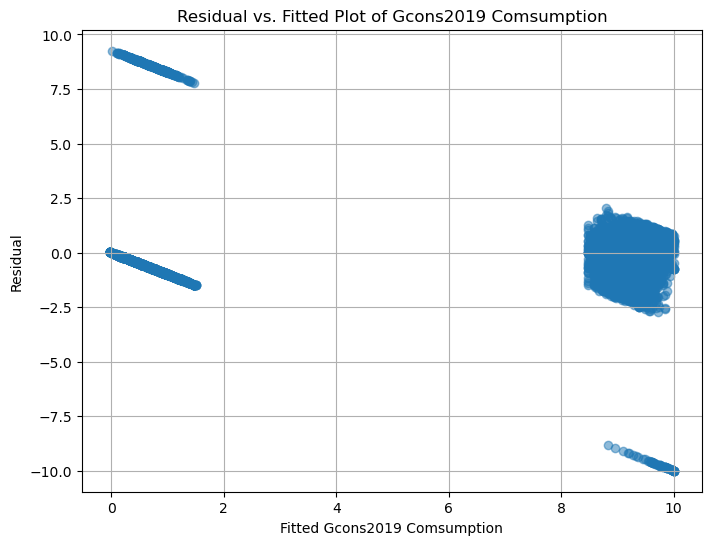

In [22]:
# Residuals vs. Fitted plot

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
plt.scatter(Gcons2019_comsumption_result.fittedvalues, Gcons2019_comsumption_result.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted Gcons2019 Comsumption')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of Gcons2019 Comsumption')
# Adding grid lines
plt.grid(True)
plt.show()

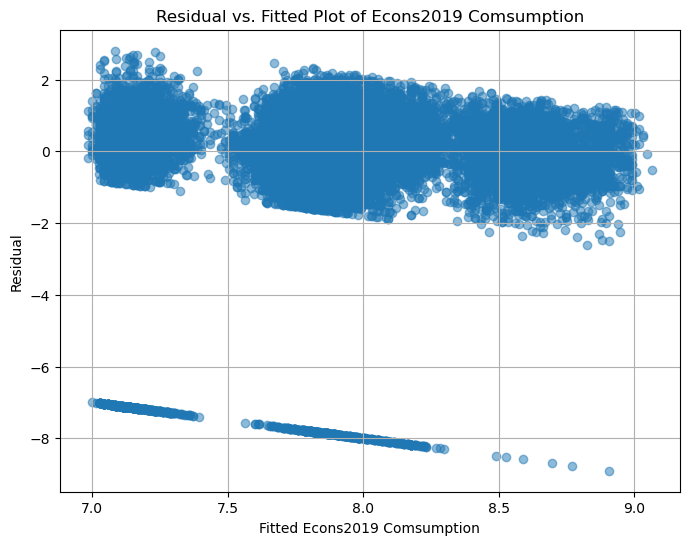

In [23]:
# Residuals vs. Fitted plot

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
plt.scatter(Econs2019_comsumption_result.fittedvalues, Econs2019_comsumption_result.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted Econs2019 Comsumption')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of Econs2019 Comsumption')
# Adding grid lines
plt.grid(True)
plt.show()

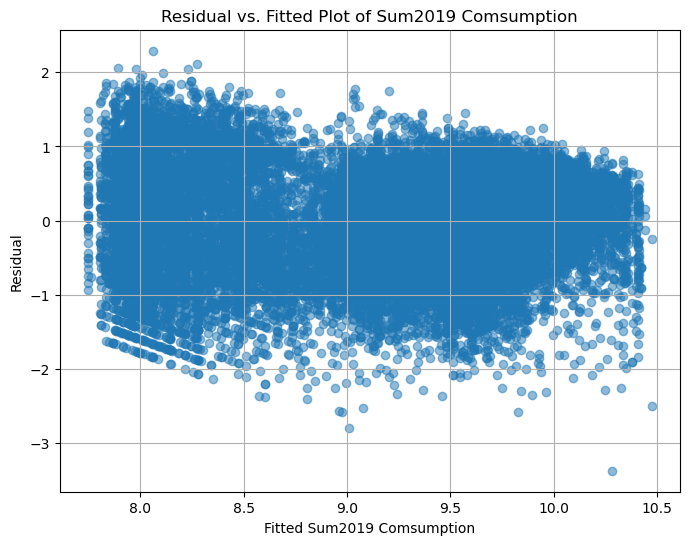

In [24]:
# Residuals vs. Fitted plot

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
plt.scatter(Sum2019_comsumption_result.fittedvalues, Sum2019_comsumption_result.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted Sum2019 Comsumption')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of Sum2019 Comsumption')
# Adding grid lines
plt.grid(True)
plt.show()

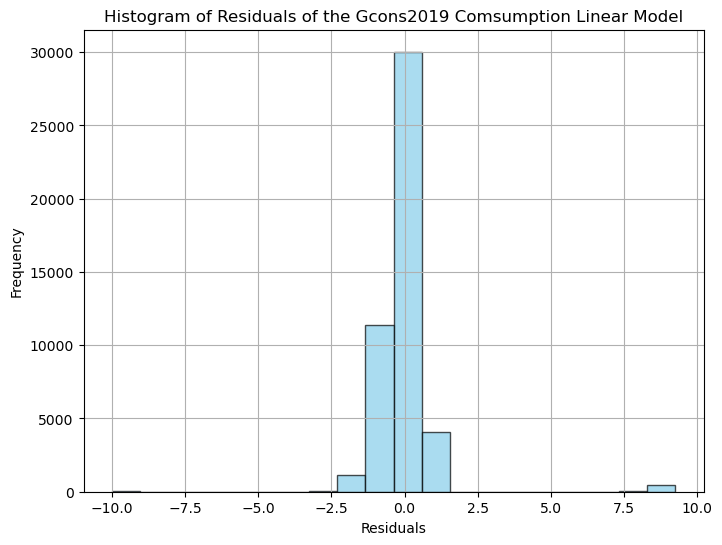

In [25]:
# Histogram of residuals

# Set the figure size
plt.figure(figsize=(8, 6))  

# Plotting the histogram
plt.hist(Gcons2019_comsumption_result.resid, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals of the Gcons2019 Comsumption Linear Model')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

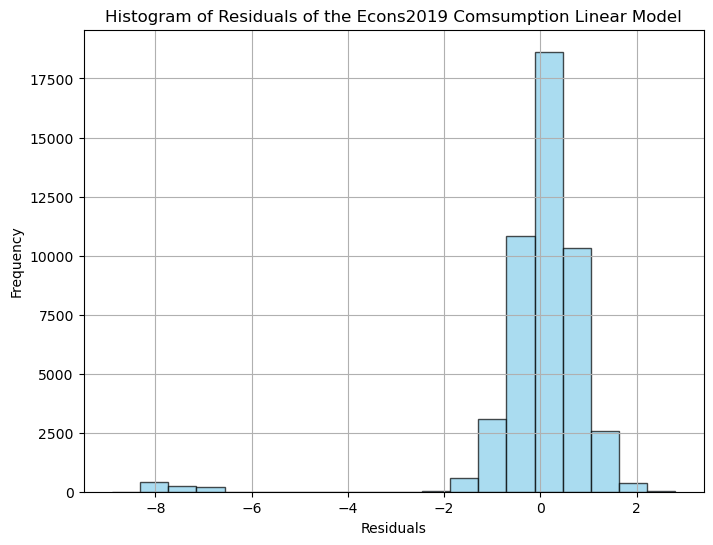

In [26]:
# Histogram of residuals

# Set the figure size
plt.figure(figsize=(8, 6))  

# Plotting the histogram
plt.hist(Econs2019_comsumption_result.resid, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals of the Econs2019 Comsumption Linear Model')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

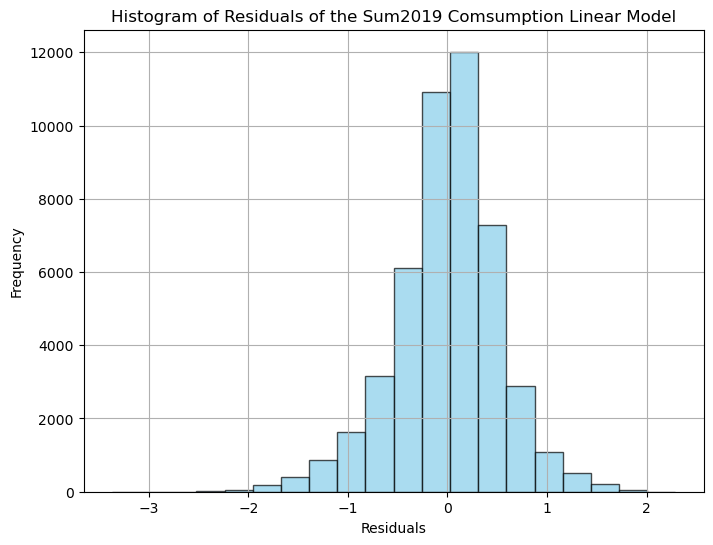

In [27]:
# Histogram of residuals

# Set the figure size
plt.figure(figsize=(8, 6))  

# Plotting the histogram
plt.hist(Sum2019_comsumption_result.resid, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals of the Sum2019 Comsumption Linear Model')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

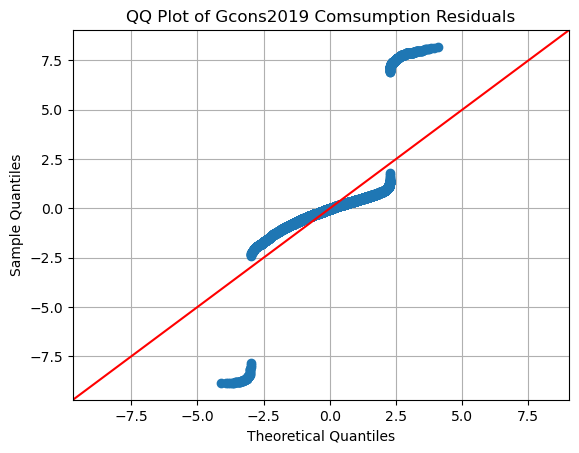

In [28]:
# the QQ plot of residuals

fig = sm.qqplot(Gcons2019_comsumption_result.resid, fit=True, line="45")
plt.title('QQ Plot of Gcons2019 Comsumption Residuals')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

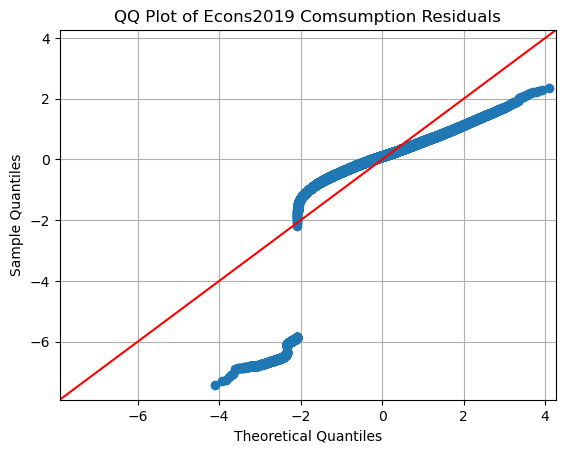

In [29]:
# the QQ plot of residuals

fig = sm.qqplot(Econs2019_comsumption_result.resid, fit=True, line="45")
plt.title('QQ Plot of Econs2019 Comsumption Residuals')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

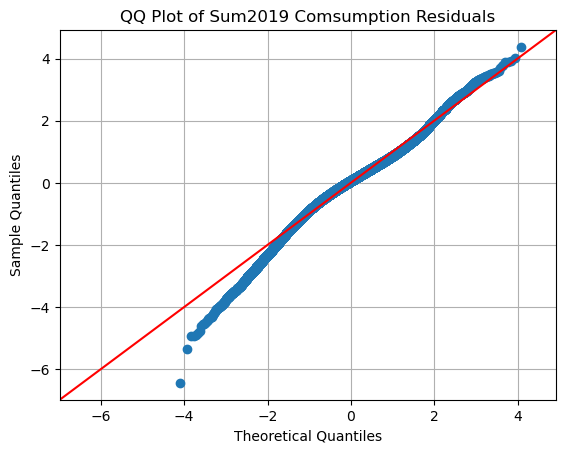

In [30]:
# the QQ plot of residuals

fig = sm.qqplot(Sum2019_comsumption_result.resid, fit=True, line="45")
plt.title('QQ Plot of Sum2019 Comsumption Residuals')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

# Clustering analysis

## Data standardisation

In [31]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

data_standardised = df_filtered.copy()
for c in df_filtered.columns[10:].values:
    data_standardised[c] = mms.fit_transform(np.log1p(df_filtered[c]).values.reshape(-1,1))

data_standardised.head()
data_standardised.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  int64  
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         47335 non-null  float64
 11  Gcons2018         47335 non-null  float64
 12  Gcons2017         47335 non-null  float64
 13  Gcons2016         47335 non-null  float64
 14  Gcons2015         47335 non-null  float64
 15  Gcons2014         47335 non-null  float64
 16  Gcons2013         47335 non-null  float64
 17

## Kmeans clustering

In [32]:
# data_standardised_cons = data_standardised.iloc[:,10:]
data_standardised_cons = data_standardised.loc[:,['Gcons2019','Econs2019']]
# we fix the random_state so that the kmeans result is reproducible
num_clusters = 3
random_state_seed = 100

kmeans_output = sklc.KMeans(n_clusters=num_clusters, random_state=random_state_seed).fit(data_standardised_cons)

# Sanity check
print(kmeans_output)                                              

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=100)


In [33]:
# This line creates a list giving the final cluster number of each point:
clustering_ids_kmeans = kmeans_output.labels_

# You can print the clustering IDs to get an ordered list of labels
print(clustering_ids_kmeans)

# we will combine the clustering IDs to the dataframe
data_cluster = data_standardised_cons.assign(cluster_id = clustering_ids_kmeans)

#Have a look at the result:
data_cluster.info()

[0 0 0 ... 0 0 0]
<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gcons2019   47335 non-null  float64
 1   Econs2019   47335 non-null  float64
 2   cluster_id  47335 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 1.3 MB


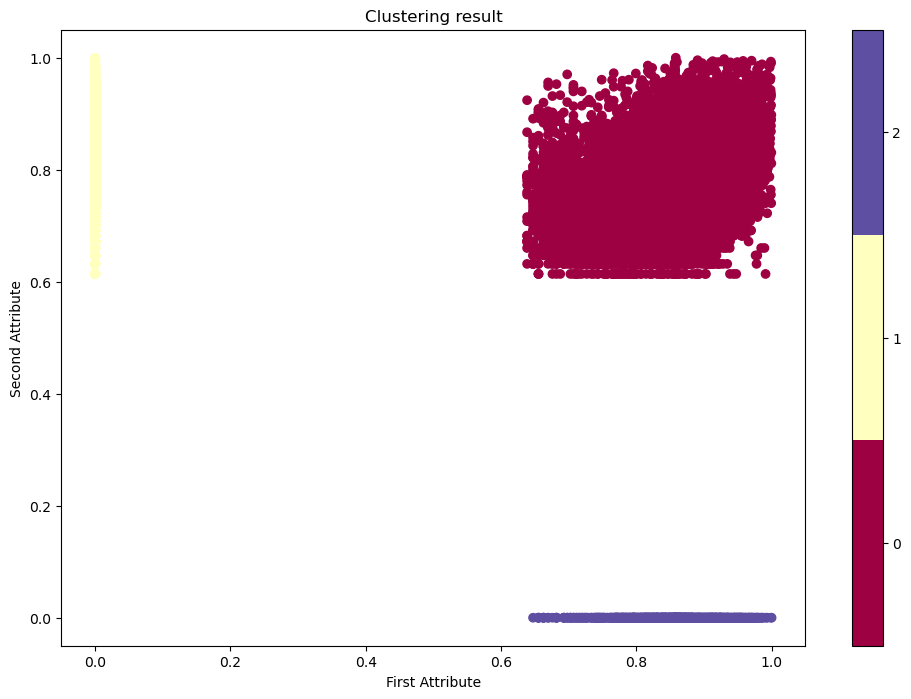

In [34]:
fig, ax = plt.subplots(figsize=(12,8))

# number of clusters
n_clusters = data_cluster.cluster_id.nunique()

# get discrete colormap
cmap = plt.get_cmap('Spectral', n_clusters)

# scatter points
scatter = ax.scatter(data_cluster.Gcons2019, data_cluster.Econs2019, c=data_cluster.cluster_id, cmap=cmap)
ax.set_xlabel('First Attribute')
ax.set_ylabel('Second Attribute')
ax.set_title('Clustering result')

# add colorbar
cbar = plt.colorbar(scatter)

# set ticks locations (not very elegant, but it works):
# - shift by 0.5
# - scale so that the last value is at the center of the last color
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar.set_ticks(tick_locs)

# set tick labels (as before)
cbar.set_ticklabels(np.arange(n_clusters))

## Multivariate nonlinear regression

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Preparing the data for polynomial regression
X = df_filtered_VIF
y_gcons = df_filtered['Gcons2019']
y_econs = df_filtered['Econs2019']
y_sum = df_filtered['Sum2019']

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Splitting the data into training and testing sets for 'Gcons2019'
X_train_gcons, X_test_gcons, y_train_gcons, y_test_gcons = train_test_split(X_poly, y_gcons, test_size=0.3, random_state=42)

# Fit a linear regression model on the polynomial features for 'Gcons2019'
model_gcons = LinearRegression()
model_gcons.fit(X_train_gcons, y_train_gcons)

# Predict on the test set for 'Gcons2019'
y_pred_gcons = model_gcons.predict(X_test_gcons)

# Calculate metrics for 'Gcons2019'
mse_gcons = mean_squared_error(y_test_gcons, y_pred_gcons)
r2_gcons = r2_score(y_test_gcons, y_pred_gcons)

# Splitting the data into training and testing sets for 'Econs2019'
X_train_econs, X_test_econs, y_train_econs, y_test_econs = train_test_split(X_poly, y_econs, test_size=0.3, random_state=42)

# Fit a linear regression model on the polynomial features for 'Econs2019'
model_econs = LinearRegression()
model_econs.fit(X_train_econs, y_train_econs)

# Predict on the test set for 'Econs2019'
y_pred_econs = model_econs.predict(X_test_econs)

# Calculate metrics for 'Econs2019'
mse_econs = mean_squared_error(y_test_econs, y_pred_econs)
r2_econs = r2_score(y_test_econs, y_pred_econs)

# Splitting the data into training and testing sets for 'Sum2019'
X_train_sum, X_test_sum, y_train_sum, y_test_sum = train_test_split(X_poly, y_sum, test_size=0.3, random_state=42)

# Fit a linear regression model on the polynomial features for 'Sum2019'
model_sum = LinearRegression()
model_sum.fit(X_train_sum, y_train_sum)

# Predict on the test set for 'Sum2019'
y_pred_sum = model_sum.predict(X_test_sum)

# Calculate metrics for 'Sum2019'
mse_sum = mean_squared_error(y_test_sum, y_pred_sum)
r2_sum = r2_score(y_test_sum, y_pred_sum)

# Printing the results
print("Gcons2019 Model - MSE:", mse_gcons, "R2:", r2_gcons)
print("Econs2019 Model - MSE:", mse_econs, "R2:", r2_econs)
print("Sum2019 Model - MSE:", mse_sum, "R2:", r2_sum)

# Displaying detailed information about the 'Gcons2019' model
print("Gcons2019 Model Coefficients:", model_gcons.coef_)
print("Gcons2019 Model Intercept:", model_gcons.intercept_)

# Displaying detailed information about the 'Econs2019' model
print("\nEcons2019 Model Coefficients:", model_econs.coef_)
print("Econs2019 Model Intercept:", model_econs.intercept_)

# Displaying detailed information about the 'Sum2019' model
print("\nSum2019 Model Coefficients:", model_sum.coef_)
print("Sum2019 Model Intercept:", model_sum.intercept_)

Gcons2019 Model - MSE: 3694832.429426675 R2: 0.9457065038839415
Econs2019 Model - MSE: 3694832.3922435697 R2: 0.5044296516490824
Sum2019 Model - MSE: 9.509732704531212e-15 R2: 1.0
Gcons2019 Model Coefficients: [ 3.89590296e+02 -2.62810684e+02  2.54673530e+02  8.98327296e+01
  2.02421465e+02 -2.05520179e+02 -5.06271320e+02 -5.90166769e+01
 -1.55426168e-01 -2.92522526e-02  5.89344614e-02 -5.25282029e-02
  1.52077003e+00 -1.47420224e+02 -4.96708614e+02 -2.94466916e+02
 -3.59987476e+02 -6.89229024e+01  3.25440048e+02  2.62061326e+01
  5.47956991e+02  3.38038961e+02  5.02105171e+02 -1.19732501e+02
  3.38464219e+02  6.09688872e+02  9.48724013e+00  5.82429411e+01
  5.29460609e+01 -5.89644846e-01 -1.08664714e+02  3.43930464e+01
  2.22440117e+02 -2.02761724e+02 -6.89278055e-04 -4.61770581e-03
 -6.93511830e-03  3.62700575e-03 -1.29094314e-02 -1.37991705e+02
 -7.74483305e+01 -6.68787778e+01 -1.77398703e+02 -2.06718305e+02
 -1.15105658e+02 -6.40048381e+01 -9.14273499e+01 -1.40531697e+02
 -9.444875

## Random effects model

In [36]:
pip install linearmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 7.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import numpy as np
from linearmodels.panel import RandomEffects

file_path = 'Data_clean/df_filtered.csv'
df_filtered = pd.read_csv(file_path)

# 重构数据为面板数据格式
panel_data = pd.DataFrame()
for year in range(2005, 2015):
    temp_df = df_filtered.copy()
    temp_df['Year'] = year
    temp_df['Econs'] = df_filtered[f'Econs{year}']
    panel_data = pd.concat([panel_data, temp_df], ignore_index=True)

# 对因变量进行对数转换
panel_data['Econs_log'] = np.log(panel_data['Econs'] + 1) # 加1以避免对0取对数

# 选择一些自变量
# 假设我们根据结果选择了以下变量
selected_vars = ['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND', 'IMD_BAND_ENG', 
                    'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL', 'PROP_TYPE']

# 将分类变量转换为哑变量
panel_data = pd.get_dummies(panel_data, columns=selected_vars, drop_first=True)

# 重命名列名以避免语法问题
panel_data.columns = [col.replace('.', '_').replace(' ', '_').replace('-', '_') for col in panel_data.columns]

# 设置因变量和自变量
dependent_var = 'Econs_log'
independent_vars = panel_data.columns.difference([dependent_var, 'REGION', 'Year', 'Econs'] + selected_vars)

# 将数据转换为面板数据格式
panel_data = panel_data.set_index(['REGION', 'Year'])

# 创建并拟合随机效应模型
model = RandomEffects(panel_data[dependent_var], panel_data[independent_vars])
result = model.fit()

# 显示回归结果
print(result.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:              Econs_log   R-squared:                        0.9684
Estimator:              RandomEffects   R-squared (Between):              0.9992
No. Observations:              473350   R-squared (Within):              -0.2867
Date:                Mon, Dec 11 2023   R-squared (Overall):              0.9684
Time:                        11:58:23   Log-likelihood                -8.439e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.451e+05
Entities:                           9   P-value                           0.0000
Avg Obs:                    5.259e+04   Distribution:               F(42,473308)
Min Obs:                    2.394e+04                                           
Max Obs:                    7.727e+04   F-statistic (robust):          3.451e+05
                            

In [38]:
import pandas as pd
import numpy as np
from linearmodels.panel import RandomEffects

file_path = 'Data_clean/df_filtered.csv'
df_filtered = pd.read_csv(file_path)

# 重构数据为面板数据格式
panel_data = pd.DataFrame()
for year in range(2005, 2015):
    temp_df = df_filtered.copy()
    temp_df['Year'] = year
    temp_df['Econs'] = df_filtered[f'Econs{year}']
    panel_data = pd.concat([panel_data, temp_df], ignore_index=True)

# 对因变量进行对数转换
panel_data['Econs_log'] = np.log(panel_data['Econs'] + 1) # 加1以避免对0取对数

# 选择一些自变量
# 假设我们根据结果选择了以下变量
selected_vars = ['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND', 'IMD_BAND_ENG', 
                    'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL', 'PROP_TYPE']

# 将分类变量转换为哑变量
panel_data = pd.get_dummies(panel_data, columns=selected_vars, drop_first=True)

# 重命名列名以避免语法问题
panel_data.columns = [col.replace('.', '_').replace(' ', '_').replace('-', '_') for col in panel_data.columns]

# 设置因变量和自变量
dependent_var = 'Econs_log'
independent_vars = panel_data.columns.difference([dependent_var, 'REGION', 'Year', 'Econs'] + selected_vars)

# 将数据转换为面板数据格式
panel_data = panel_data.set_index(['REGION', 'Year'])

# 创建并拟合随机效应模型
model = RandomEffects(panel_data[dependent_var], panel_data[independent_vars])
result = model.fit()

# 显示回归结果
print(result.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:              Econs_log   R-squared:                        0.9684
Estimator:              RandomEffects   R-squared (Between):              0.9992
No. Observations:              473350   R-squared (Within):              -0.2867
Date:                Mon, Dec 11 2023   R-squared (Overall):              0.9684
Time:                        11:58:32   Log-likelihood                -8.439e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.451e+05
Entities:                           9   P-value                           0.0000
Avg Obs:                    5.259e+04   Distribution:               F(42,473308)
Min Obs:                    2.394e+04                                           
Max Obs:                    7.727e+04   F-statistic (robust):          3.451e+05
                            

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Load dataset
df = pd.read_csv('Data_clean/sum.csv')

# Separate the independent and dependent variables
X = df.drop('Sum2019', axis=1)
y = df['Sum2019']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    #'Ridge': Ridge(),
    #'Lasso': Lasso(),
    #'Random Forest': RandomForestRegressor(random_state=42),
    #'SVR': make_pipeline(StandardScaler(), SVR()),
    #'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=2), Ridge()),
    'Linear Regression': LinearRegression()
}

# Train and evaluate the models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'MSE': mse, 'R2': r2})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df.sort_values(by='R2', ascending=False))


               Model           MSE        R2
0  Linear Regression  4.415032e+07  0.430575
